# Autoencoder Example/Excercise

This notebook is an exercise in creating an autoencoder from the MNIST handwritten digit data set (the "Hello, World" of ML datasets).

We will be using [this example as the basis for our autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html)

## Table of contents:

* [Imported Libraries](#imports)
* [Loading MNIST Dataset](#load)
* [Simplest autoencoder](#simple)
  * [Comple the model](#simple-compile)
  * [Format the data](#simple-format)
  * [Train the network](#simple-train)
  * [Visualize the reconstruction](#simple-viz)
  * [Adding sparsity](#simple-sparse)
* [Convolutional Autoencoder](#convolutional)
  - [Load and format data](#conv-data)
  - [Train model](#conv-train)
* [Deep Convolutional Autoencoder](#deep)
  * [View learned representation](#deep-viz)
  * [De-noising example](#deep-noise)

# Imported Libraries <a class="anchor" id="imports"></a>

Start by importing the following libraries.

**NOTE:**

- Versions for keras, tensorflow, scikit-learn
    * You may install these versions in anaconda *via* `$: conda install keras=2.2.2`
- If you have an Nvidia gpu, you can install gpu-enabled versions of tensorflow/keras for improved performance:
    * `$: conda install -c defaults tensorflow-gpu keras-gpu`
    * **NOTE:** As of 2018-10-02 the conda-forge versions of the above were not working with my GPU (Quadro P5000)

In [39]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

keras version: 2.2.4
tensorflow version: 1.12.0
scikit-learn version: 0.20.0


# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already nicely split into training and testing data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


# Simplest possible autoencoder <a class="anchor" id="simple"></a>

**NOTE:** this walkthrough uses the Keras *FUNCTIONAL* API rather than the object-oriented one used in previous examples

In [17]:
# specify the number of reduced variables we want
# our so-called "bottleneck" size
encoding_dim = 32

# specify an input image placeholder with the
# appropriate size
input_img = Input(shape=(784,))

# create the encoded layer. This is the layer
# with the reduced dimensions, the "bottleneck"
encoded = Dense(encoding_dim, activation='relu')(input_img)

# created the decoded layer. This will be the
# reconstructed image (and will be rather lossy)
decoded = Dense(784, activation='sigmoid')(encoded)
# hypothesis: sigmoid rather than linear used because
# the MNIST dataset is black and white, and a pixel
# should be off or on, not really *any* value

# create the actual model object
autoencoder = Model(input_img, decoded)

In [18]:
# create a separate model just for the encoder portion
encoder = Model(input_img, encoded)

# create a separate model just for the decoder portion
encoded_input = Input(shape=(encoding_dim,))
# we know the decoder layer in this case is the final
# layer of the autoencoder
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Compile the model <a class="anchor" id="simple-compile"></a>

In [19]:
# compile the autoencoder
autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")

## Format the data <a class="anchor" id="simple format"></a>

Normalize and flatten

In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)
X_train = X_train.astype("float32") / 255.0
X_train = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:3]))
X_test = X_test.astype("float32") / 255.0
X_test = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:3]))

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


## Train the autoencoder <a class="anchor" id="simple-train"></a>

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=[early_stop])

autoencoder.summary()

<IPython.core.display.Javascript object>


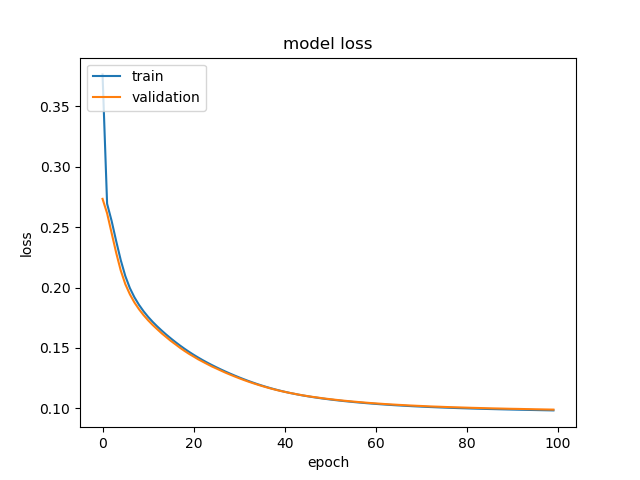

In [24]:
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

## Visualize the reconstruction <a class="anchor" id="simple-viz"></a>

Let's view a few examples of the reconstructed images. We will need to encode and decode the images (this is why we construct the model with the functional API)

In [25]:
encoded_images = encoder.predict(X_test)
decoded_images = decoder.predict(encoded_images)

<IPython.core.display.Javascript object>


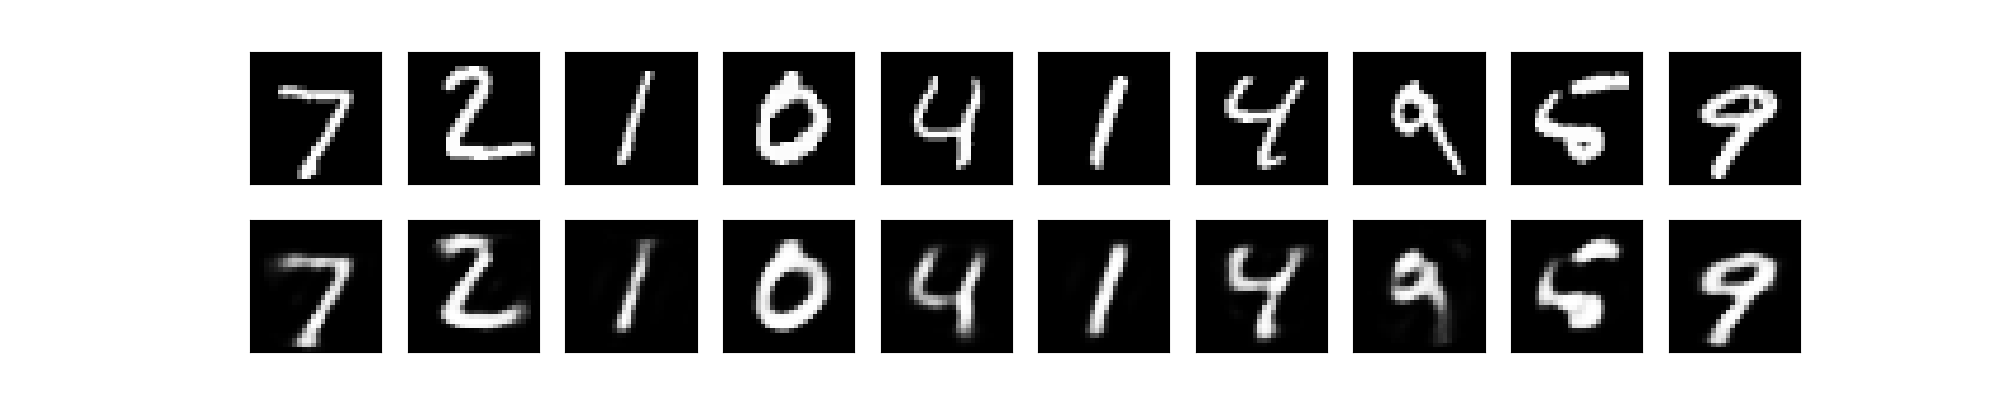

In [28]:
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

honestly, for a single layer on a flattened image, that's pretty darn good

## Adding sparsity constraint <a class="anchor" id="simple-sparse"></a>

According to the walkthrough, this neural network is likely to learn an approximation of the PCA. We can limit the activity of the network by using a [sparsity](http://ufldl.stanford.edu/wiki/index.php/Autoencoders_and_Sparsity) constraint. This sparsity should enforce the network to learn more about the higher-dimensional data by forcing fewer neurons to be active at any given time (we are forcing the network to attempt to learn the structure of the higher-dimensional data)

In [33]:
from keras import regularizers

# specify the number of reduced variables we want
encoding_dim = 32
# specify an input image placeholder with the
# appropriate size
input_img = Input(shape=(784,))
# create the encoded layer.
encoded = Dense(encoding_dim,
                activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)

# created the decoded layer. This will be the
# reconstructed image (and will be rather lossy)
decoded = Dense(784, activation='sigmoid')(encoded)

# create the actual model object
autoencoder = Model(input_img, decoded)
# compile model
autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")

In [34]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=[early_stop])

autoencoder.summary()

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 13us/step - loss: 0.6788 - val_loss: 0.6570
Epoch 2/100
48000/48000 [==============================] - 0s 10us/step - loss: 0.6404 - val_loss: 0.6240
Epoch 3/100
48000/48000 [==============================] - 0s 10us/step - loss: 0.6092 - val_loss: 0.5946
Epoch 4/100
48000/48000 [==============================] - 0s 9us/step - loss: 0.5816 - val_loss: 0.5685
Epoch 5/100
48000/48000 [==============================] - 0s 10us/step - loss: 0.5569 - val_loss: 0.5452
Epoch 6/100
48000/48000 [==============================] - 0s 9us/step - loss: 0.5349 - val_loss: 0.5244
Epoch 7/100
48000/48000 [==============================] - 0s 10us/step - loss: 0.5153 - val_loss: 0.5058
Epoch 8/100
48000/48000 [==============================] - 0s 9us/step - loss: 0.4976 - val_loss: 0.4891
Epoch 9/100
48000/48000 [==============================] - 0s 9us/step - loss: 0.4818 - val_loss: 0.4741


<IPython.core.display.Javascript object>


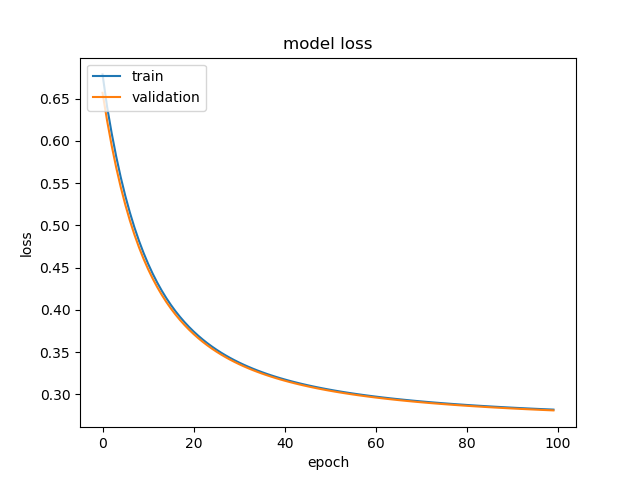

In [35]:
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


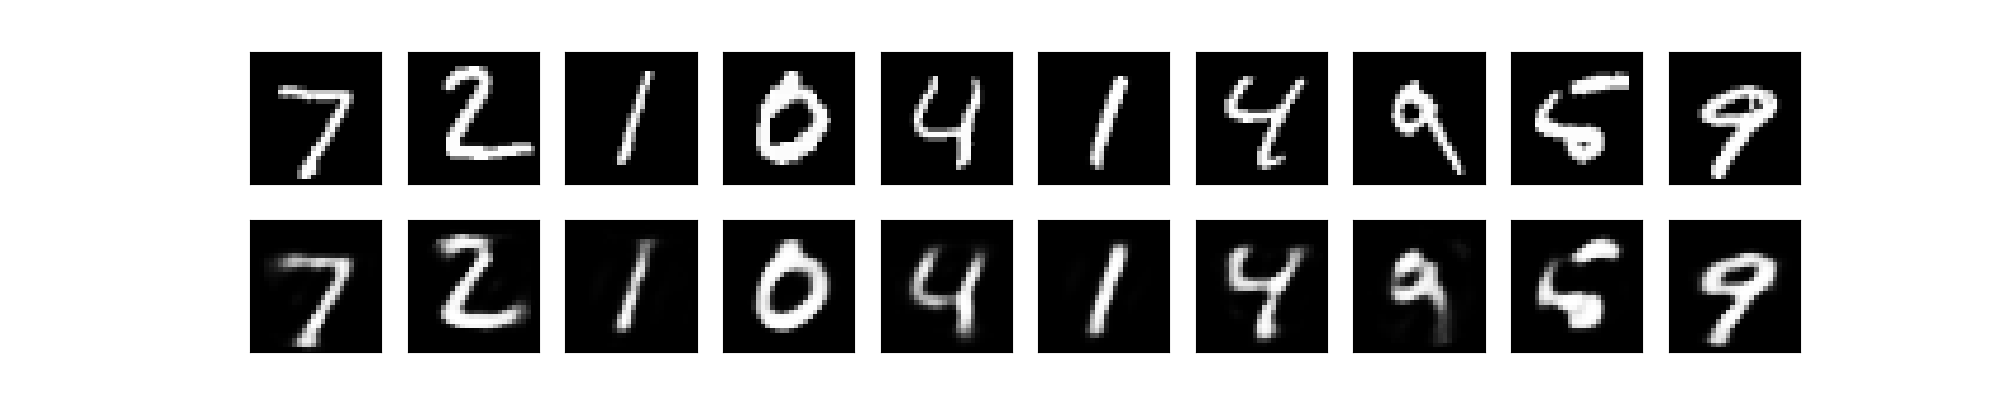

In [36]:
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

I am electing to skip the dense deep autoencoder and skip directly to the convolutional autoencoder

# Convolutional Autoencoder <a class="anchor" id="convolution"></a>

In [44]:
# specify the input layer as our 2D image
input_img = Input(shape=(28, 28, 1))

# specify a 3x3 convolution learning 16 filters
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(input_img)
# pool the image (downsample)
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 8 filters
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# pool the image
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 16 filters
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# create our encoded data
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# (note this is not "flat", although a simple flatten layer
# would easily fix that)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# now start decoding
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(encoded)
# make the image larger (upsample)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# create the output layer
decoded = Convolution2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


## Load and format data <a class="anchor" id="conv-data"></a>

In [41]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)
X_train = X_train.astype("float32") / 255.0
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.astype("float32") / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


## Train model <a class="anchor" id="conv-train"></a>

In [45]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=[early_stop])

autoencoder.summary()

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 42us/step - loss: 0.2623 - val_loss: 0.1988
Epoch 2/100
48000/48000 [==============================] - 2s 33us/step - loss: 0.1858 - val_loss: 0.1739
Epoch 3/100
48000/48000 [==============================] - 2s 34us/step - loss: 0.1670 - val_loss: 0.1630
Epoch 4/100
48000/48000 [==============================] - 2s 35us/step - loss: 0.1561 - val_loss: 0.1524
Epoch 5/100
48000/48000 [==============================] - 2s 34us/step - loss: 0.1481 - val_loss: 0.1430
Epoch 6/100
48000/48000 [==============================] - 2s 36us/step - loss: 0.1418 - val_loss: 0.1410
Epoch 7/100
48000/48000 [==============================] - 2s 32us/step - loss: 0.1374 - val_loss: 0.1353
Epoch 8/100
48000/48000 [==============================] - 2s 33us/step - loss: 0.1342 - val_loss: 0.1339
Epoch 9/100
48000/48000 [==============================] - 2s 34us/step - loss: 0.1311 - val_loss: 0.1

<IPython.core.display.Javascript object>


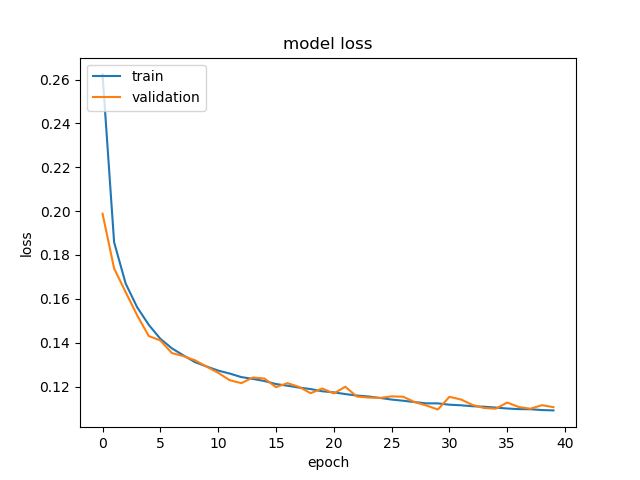

In [46]:
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


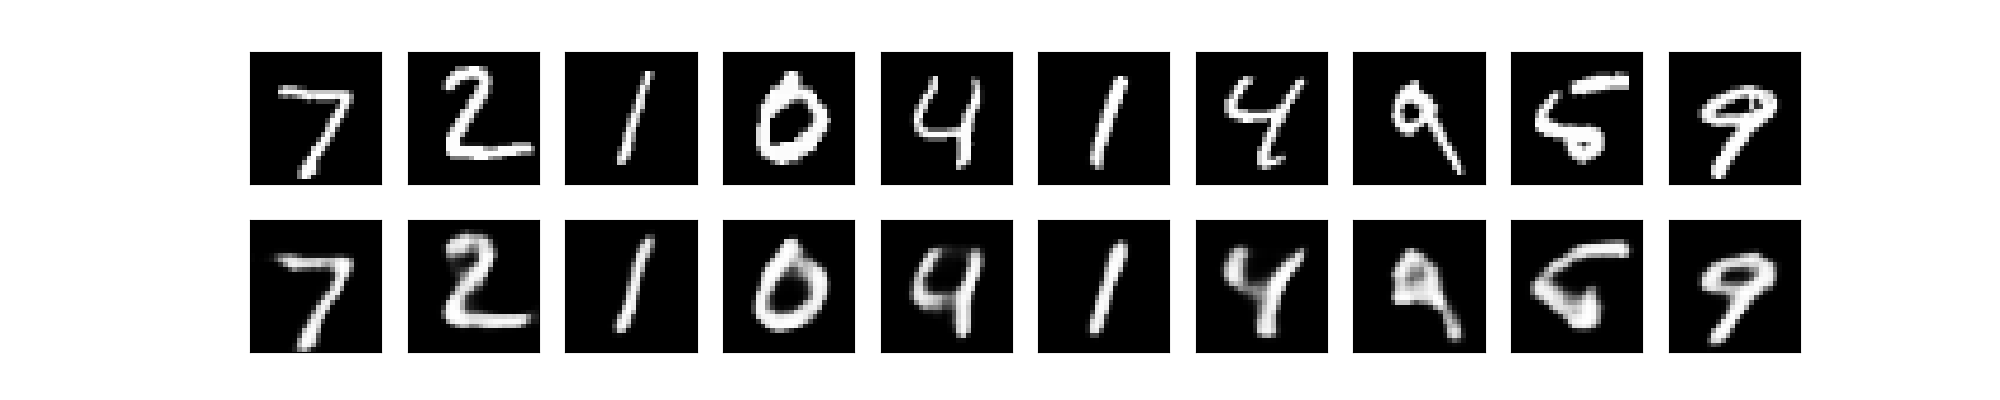

In [47]:
decoded_images = autoencoder.predict(X_test)
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Deep Convolutional Autoencoder <a class="anchor" id="deep"></a>

In [48]:
from keras.layers import Reshape

In [54]:
# specify the input layer as our 2D image
input_img = Input(shape=(28, 28, 1))

# specify a 3x3 convolution learning 16 filters
x = Convolution2D(32, (3, 3), activation='relu', padding='same')(input_img)
# pool the image (downsample)
x = Convolution2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 8 filters
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
# pool the image
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 16 filters
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# create our encoded data
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# (note this is not "flat", although a simple flatten layer
# would easily fix that)
x = MaxPooling2D((2, 2), padding='same')(x)
# here let's flatten instead of leaving as multidimensional object
encoded = Flatten()(x)
# now start decoding
# reshape
x = Reshape((4, 4, 8))(encoded)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# make the image larger (upsample)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(32, (3, 3), activation='relu')(x)
# x = Convolution2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# create the output layer
decoded = Convolution2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 16)          0         
__________

In [55]:
from keras.callbacks import TensorBoard
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=[early_stop,
                                     TensorBoard(log_dir="/tmp/autoencoder")])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 89us/step - loss: 0.2764 - val_loss: 0.1994
Epoch 2/100
48000/48000 [==============================] - 4s 73us/step - loss: 0.1875 - val_loss: 0.1733
Epoch 3/100
48000/48000 [==============================] - 3s 72us/step - loss: 0.1670 - val_loss: 0.1618
Epoch 4/100
48000/48000 [==============================] - 3s 73us/step - loss: 0.1556 - val_loss: 0.1522
Epoch 5/100
48000/48000 [==============================] - 3s 72us/step - loss: 0.1480 - val_loss: 0.1445
Epoch 6/100
48000/48000 [==============================] - 4s 73us/step - loss: 0.1421 - val_loss: 0.1415
Epoch 7/100
48000/48000 [==============================] - 4s 74us/step - loss: 0.1374 - val_loss: 0.1374
Epoch 8/100
48000/48000 [==============================] - 4s 74us/step - loss: 0.1336 - val_loss: 0.1310
Epoch 9/100
48000/48000 [==============================] - 4s 73us/step - loss: 0.1306 - val_loss: 0.1

<IPython.core.display.Javascript object>


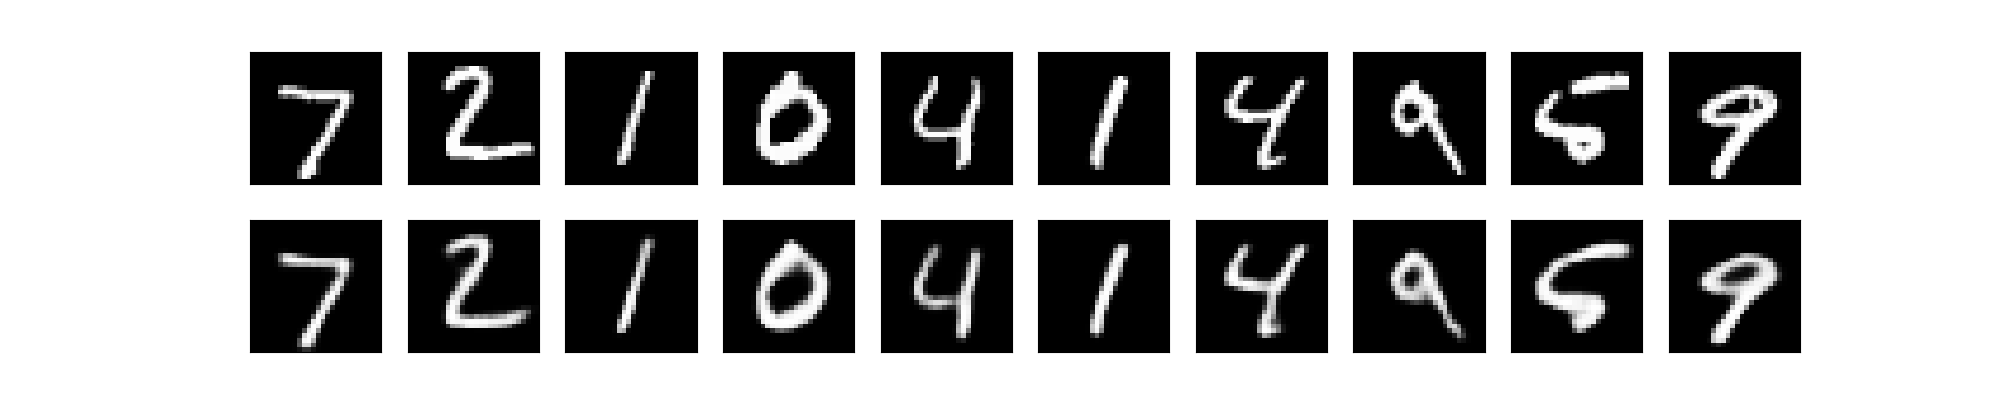

In [56]:
decoded_images = autoencoder.predict(X_test)
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

And that's bang on

## viewing the learned representation <a class="anchor" id="deep-viz"></a>

Lets plot the learned representation (We'll look at it both as a line and an image)

<IPython.core.display.Javascript object>


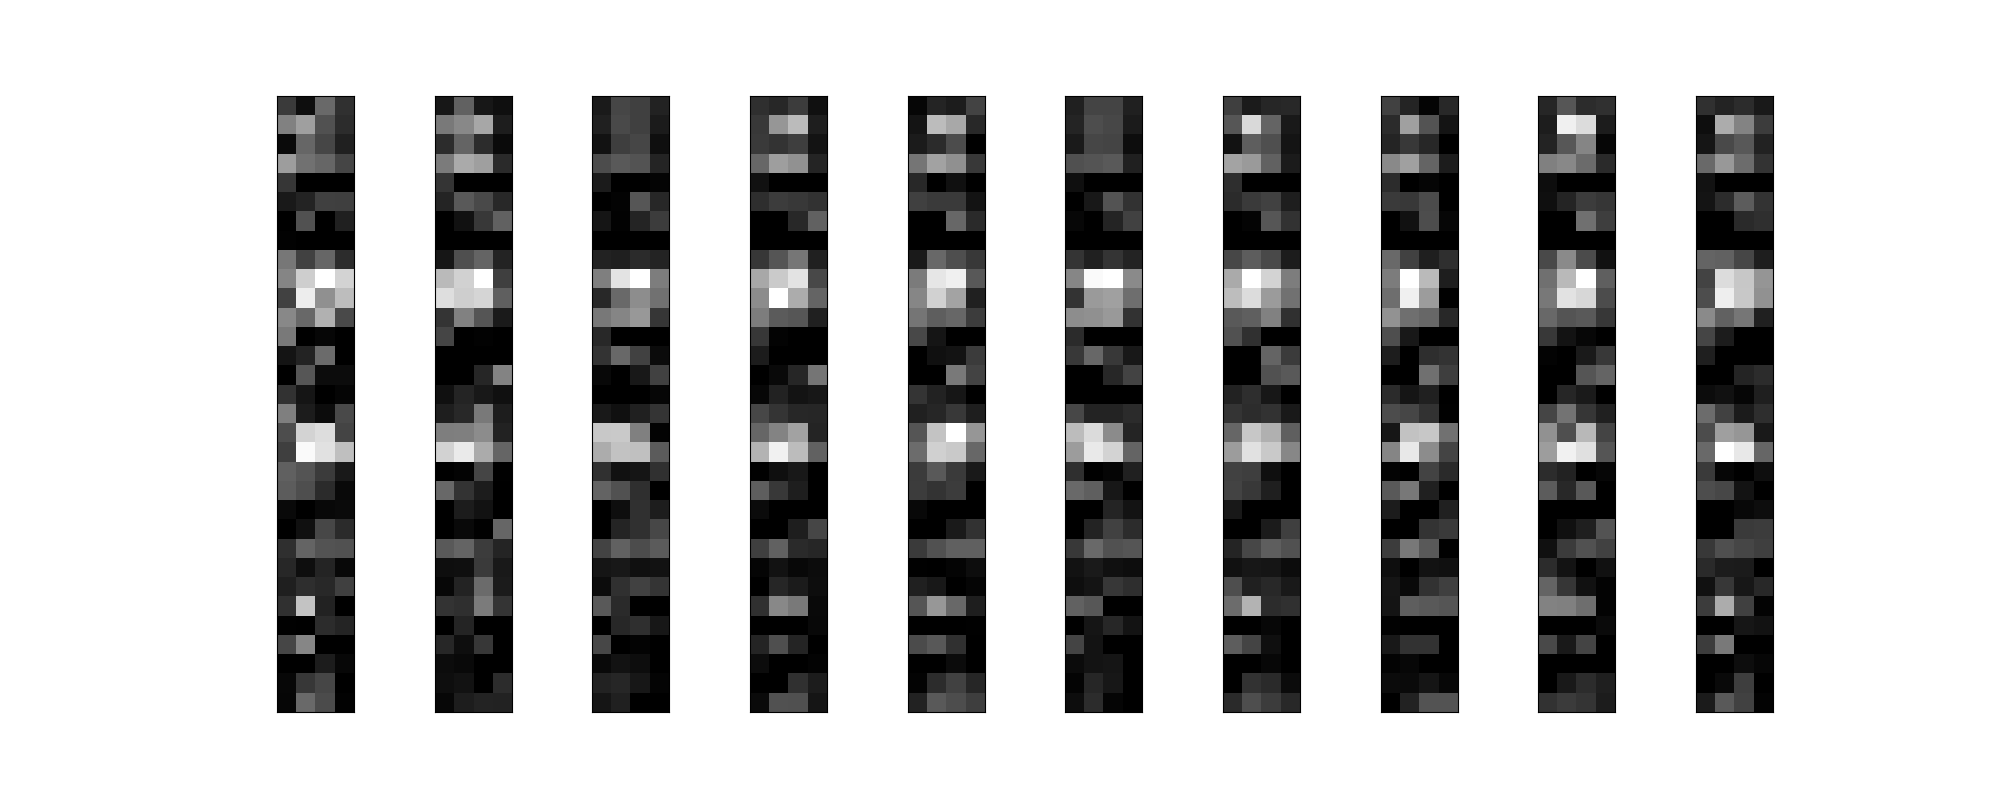

<IPython.core.display.Javascript object>


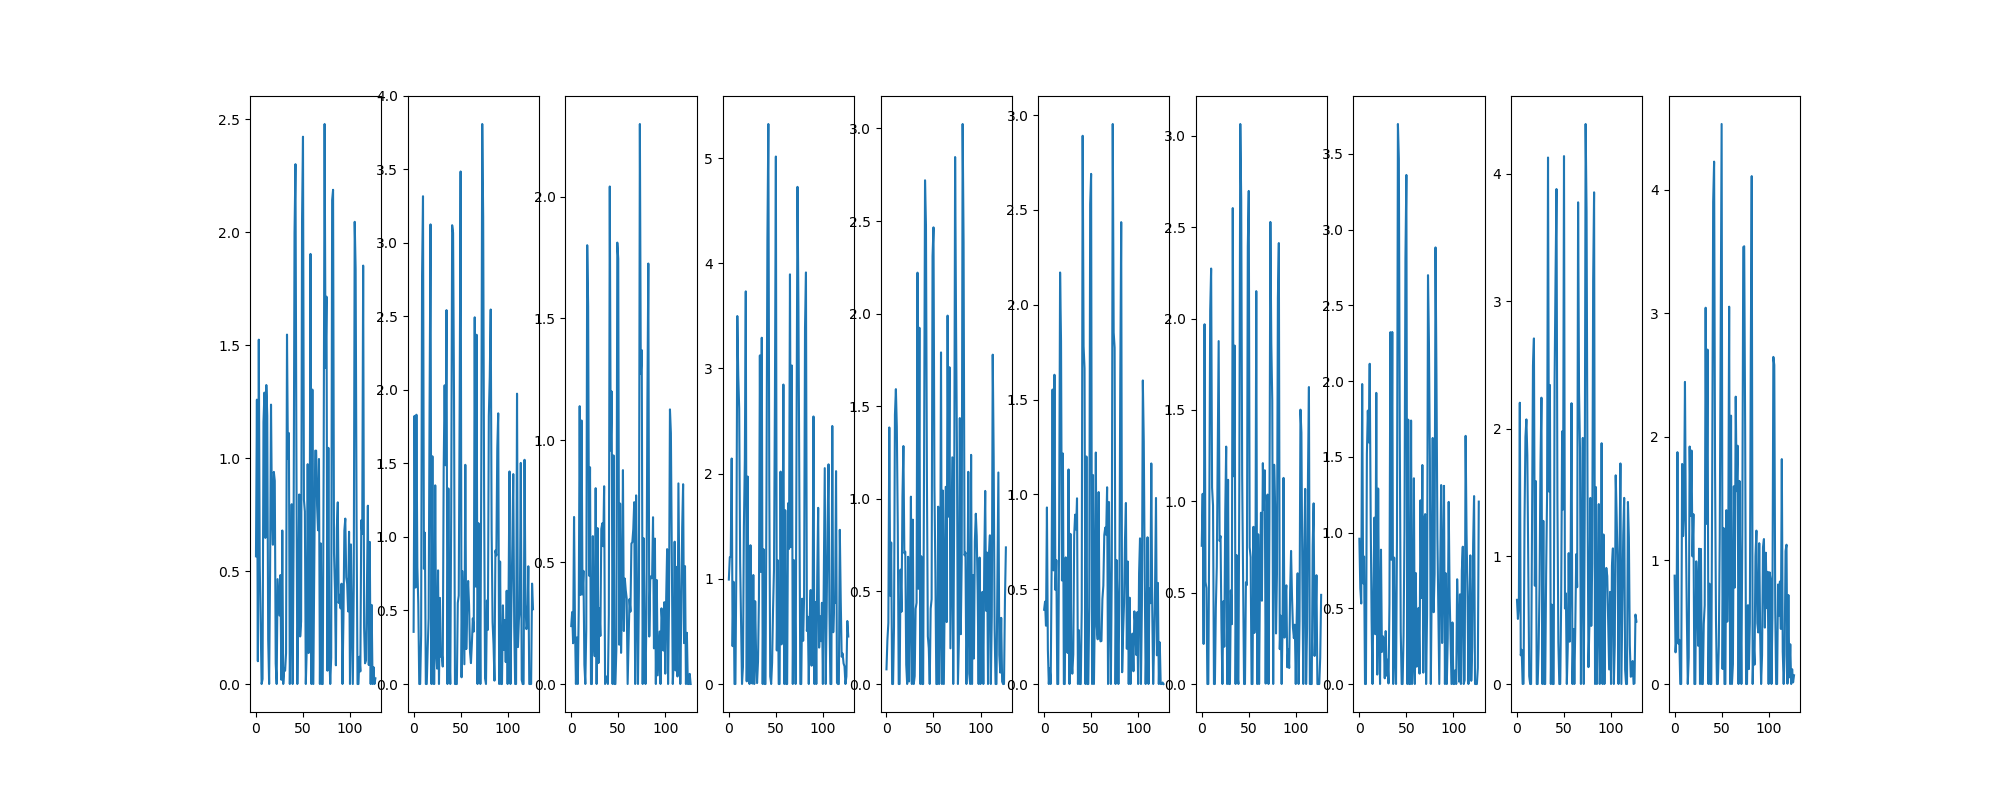

In [62]:
# create a separate model just for the encoder portion
encoder = Model(input_img, encoded)

encoded_images = encoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_images[i].reshape(4,-1).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.plot(encoded_images[i])
plt.show()

## Example: Desnoising Data <a class="anchor" id="deep-noise"></a>

Can we introduce significant noise to our data and still recover it?

<IPython.core.display.Javascript object>


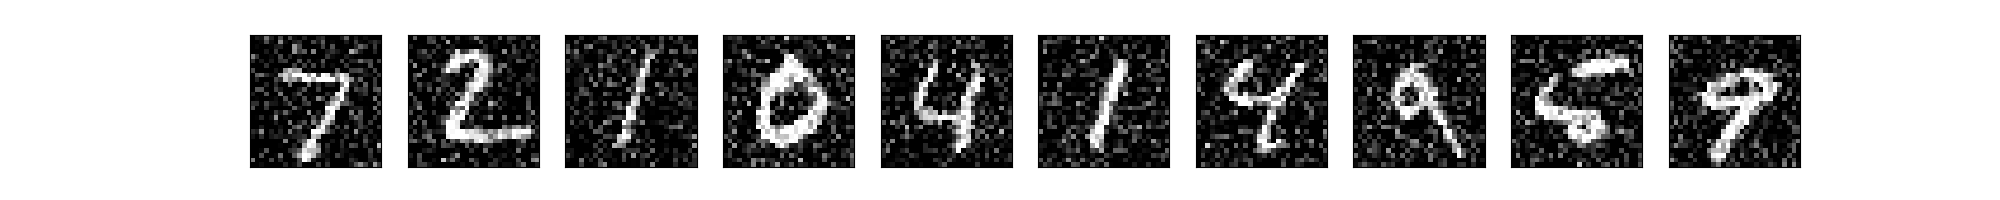

In [75]:
noise_factor = 0.25
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Now to try our autoencoder. Note we need to train a new encoder so that it understands how to de-noise (the results for the older autoencoder are included below)

<IPython.core.display.Javascript object>


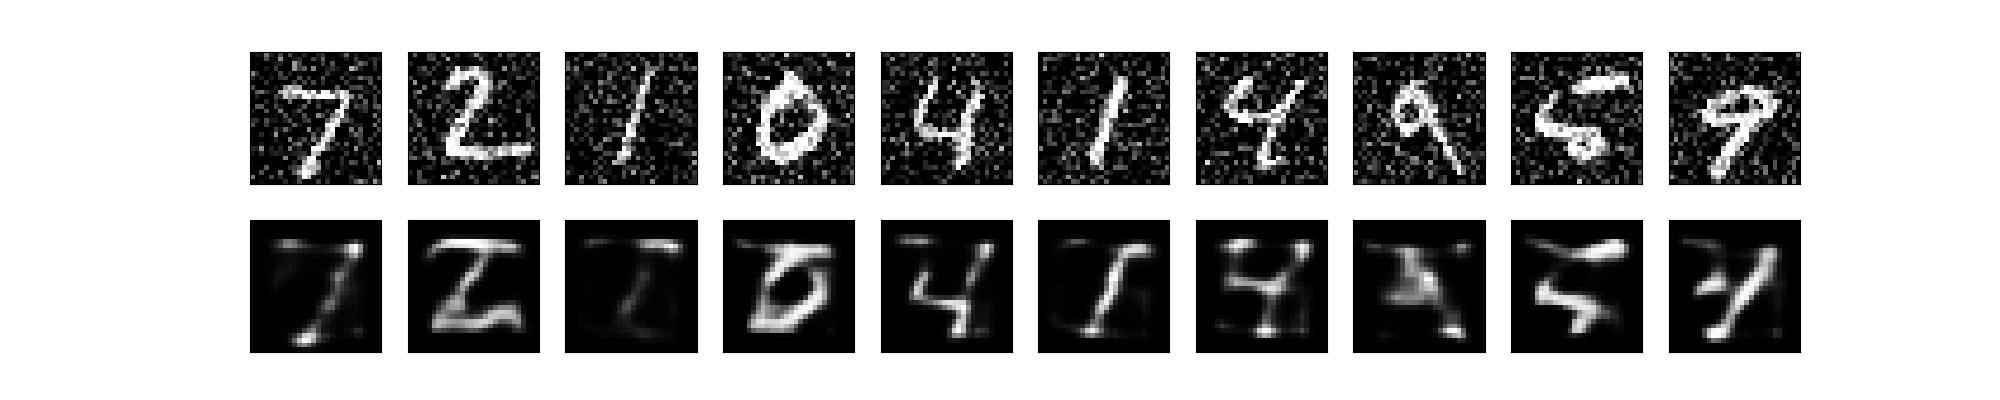

In [76]:
decoded_images = autoencoder.predict(X_test_noisy)
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [85]:
# specify the input layer as our 2D image
input_img = Input(shape=(28, 28, 1))

# specify a 3x3 convolution learning 16 filters
x = Convolution2D(32, (3, 3), activation='relu', padding='same')(input_img)
# pool the image (downsample)
x = Convolution2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 8 filters
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
# pool the image
x = MaxPooling2D((2, 2), padding='same')(x)
# specify a 3x3 convolution learning 16 filters
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# create our encoded data
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# (note this is not "flat", although a simple flatten layer
# would easily fix that)
x = MaxPooling2D((2, 2), padding='same')(x)
# here let's flatten instead of leaving as multidimensional object
encoded = Flatten()(x)
# now start decoding
# reshape
x = Reshape((4, 4, 8))(encoded)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(8, (3, 3), activation='relu', padding='same')(x)
# make the image larger (upsample)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(32, (3, 3), activation='relu')(x)
# x = Convolution2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# create the output layer
decoded = Convolution2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded, name="denoiser")
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 16)          0         
__________

In [86]:
from keras.callbacks import TensorBoard
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)
history = autoencoder.fit(X_train_noisy, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=[early_stop,
                                     TensorBoard(log_dir="/tmp/autoencoder")])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 88us/step - loss: 0.2759 - val_loss: 0.2129
Epoch 2/100
48000/48000 [==============================] - 4s 77us/step - loss: 0.1975 - val_loss: 0.1841
Epoch 3/100
48000/48000 [==============================] - 4s 76us/step - loss: 0.1698 - val_loss: 0.1627
Epoch 4/100
48000/48000 [==============================] - 4s 78us/step - loss: 0.1564 - val_loss: 0.1523
Epoch 5/100
48000/48000 [==============================] - 4s 75us/step - loss: 0.1483 - val_loss: 0.1431
Epoch 6/100
48000/48000 [==============================] - 4s 77us/step - loss: 0.1430 - val_loss: 0.1389
Epoch 7/100
48000/48000 [==============================] - 4s 78us/step - loss: 0.1383 - val_loss: 0.1409
Epoch 8/100
48000/48000 [==============================] - 4s 78us/step - loss: 0.1351 - val_loss: 0.1328
Epoch 9/100
48000/48000 [==============================] - 4s 79us/step - loss: 0.1320 - val_loss: 0.1

48000/48000 [==============================] - 4s 79us/step - loss: 0.0953 - val_loss: 0.0961
Epoch 78/100
48000/48000 [==============================] - 4s 78us/step - loss: 0.0953 - val_loss: 0.1002
Epoch 79/100
48000/48000 [==============================] - 4s 80us/step - loss: 0.0951 - val_loss: 0.0959
Epoch 80/100
48000/48000 [==============================] - 4s 79us/step - loss: 0.0947 - val_loss: 0.0929
Epoch 81/100
48000/48000 [==============================] - 4s 80us/step - loss: 0.0946 - val_loss: 0.0977
Epoch 82/100
48000/48000 [==============================] - 4s 79us/step - loss: 0.0948 - val_loss: 0.0969
Epoch 83/100
48000/48000 [==============================] - 4s 77us/step - loss: 0.0943 - val_loss: 0.0957
Epoch 84/100
48000/48000 [==============================] - 4s 80us/step - loss: 0.0946 - val_loss: 0.0950
Epoch 85/100
48000/48000 [==============================] - 4s 80us/step - loss: 0.0944 - val_loss: 0.0960
Epoch 86/100
48000/48000 [========================

<IPython.core.display.Javascript object>


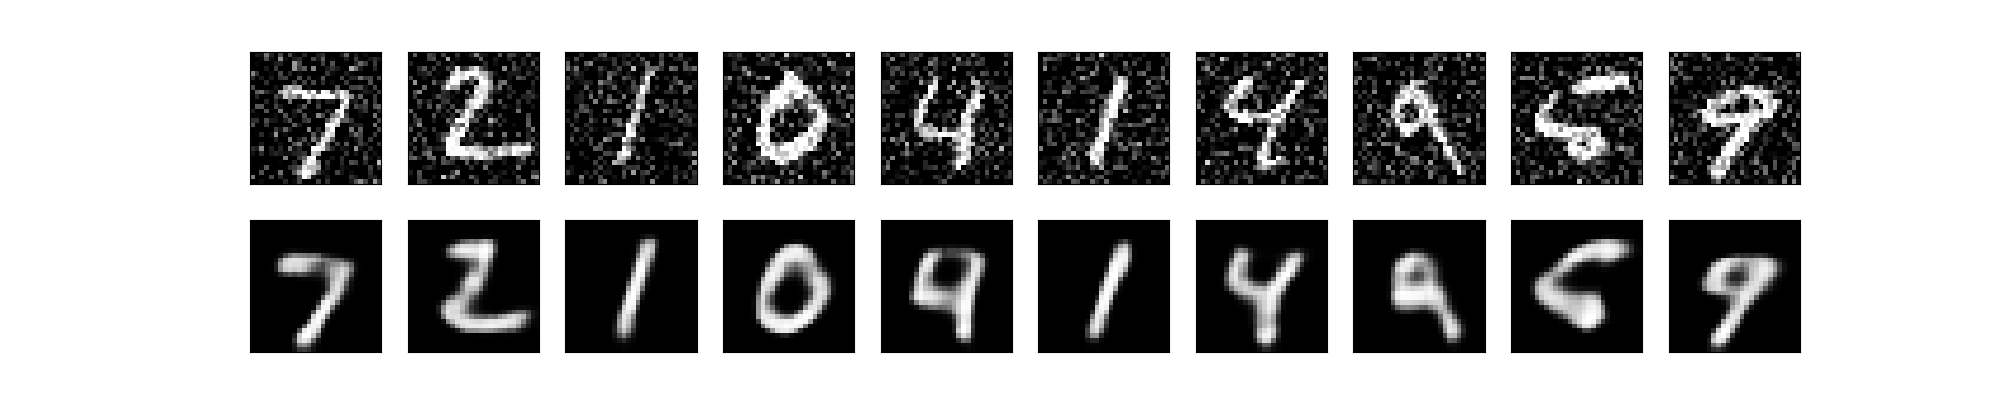

In [87]:
decoded_images = denoiser.predict(X_test_noisy)
# select how many digits to display
n = 10
# create the figure
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    # we need to reshape because we previously
    # flattened the images
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

That's pretty impressive